Необходимые библиотеки для работы сети

In [1]:
import zipfile
import PIL
import matplotlib.pyplot as plt
import numpy as np

Класс для загрузки датасета из zip архива; 

In [2]:
class DataLoader:
    def __init__(self):
        self.data_sets = dict()
        for data_set in ['train', 'val', 'test']:
            self.data_sets[f'{data_set}'] = zipfile.ZipFile(f'{data_set}.zip', 'r')
    
    def load_folder(self, set_name, type_name):
        result = []
        zip_dir = self.data_sets[set_name]
        for file_name in zip_dir.namelist():
            if len(result) >= 300:
                break
            if not file_name.startswith(type_name) or file_name[-1] == '/':
                continue
            image_file = zip_dir.open(file_name)
            image = PIL.Image.open(image_file)
            result.append(np.asarray(image))
        return np.array(result)
    
    def load_dataset(self, set_name: str='train', mask_type: str='mask'):
        t1, t2, mask = (self.load_folder(set_name, tp) for tp in ['t1', 't2', mask_type])
        assert t1.shape == t2.shape
        return np.array([np.array([t1[i], t2[i]]) for i in range(t1.shape[0])]), np.array(mask)

Константы размера изображения и маски ($32$, $64$, $128$ или $256$)

In [3]:
IMAGE_SIZE = 512
MASK_SIZE = 32

Загрузка датасета

In [4]:
data_loader = DataLoader()

x_train, y_raw_train = data_loader.load_dataset('train', f'mask_{MASK_SIZE}')
x_valid, y_raw_valid = data_loader.load_dataset('val', f'mask_{MASK_SIZE}')

Решейпнем маски датасетов в массивы, предварительно убрав три канала

In [5]:
y_train, y_valid = (np.average(i, axis=3) for i in (y_raw_train, y_raw_valid))
y_train, y_valid = (i.reshape(i.shape[0], MASK_SIZE * MASK_SIZE) for i in (y_train, y_valid))
y_train, y_valid = (i / 255 for i in (y_train, y_valid))
print(y_train, y_valid)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


С помощью функции show_place можно посмотреть на датасет

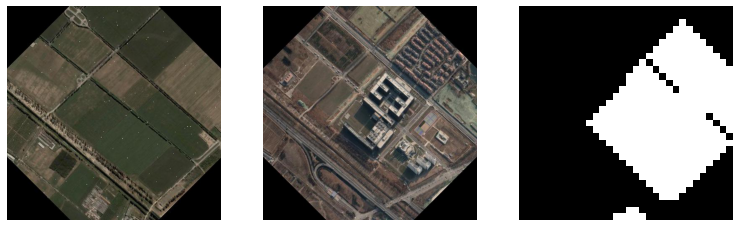

In [6]:
def show_place(place):
    fig = plt.figure(figsize=(13,13))
    for i, img in enumerate(place):
        a = fig.add_subplot(1, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')


show_place((x_train[1][0], x_train[1][1], y_raw_train[1]))

В этом датасете много сэмплов, но большая часть из них получены путем вращения картинки. Это повысит качество обучения, так как картинка с точки зрения сверточной сети будет менятся. А получить новый сэмпл поворотом намного легче, чем заново вырезать маску.

Не очень аккуратные маски в датасете в целом передадут картину. Плюс большую точность все равно сложно получить

Создаем модель и добавляем $2D$-слой.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv3D, AveragePooling3D, AveragePooling2D, Flatten
import tensorflow as tf

model = Sequential()
model.add(Conv2D(64, kernel_size=3, input_shape=(2, IMAGE_SIZE, IMAGE_SIZE, 3), activation='relu'))

In [9]:
model.add(AveragePooling3D(pool_size=(1, 2, 2), padding='valid'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))

In [11]:
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(AveragePooling3D(pool_size=(1, 2, 2), padding='valid'))
print(model.output_shape)

(None, 2, 29, 29, 64)


In [12]:
# Второй сверточный слой
model.add(Conv2D(32, kernel_size=3))
# Создаем вектор для полносвязной сети.
model.add(Flatten())

In [13]:
# Создадим однослойный перцептрон
model.add(Dense(MASK_SIZE * MASK_SIZE, activation=tf.keras.activations.sigmoid))

current = np.asarray(model(np.array([test_data[0]])))
print(current)
print(np.max(current), np.sum(current))

NameError: name 'test_data' is not defined

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

Представим датасет ожидаемые маски в виде строк

In [15]:
print(np.asarray(model(np.array([test_data[0]]))))

NameError: name 'test_data' is not defined

In [17]:
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=1)
print(hist.history)

10/10 [==============================] - 255s 24s/step - loss: 0.4347 - mean_squared_error: 0.4347 - val_loss: 0.4153 - val_mean_squared_error: 0.4153
{'loss': [0.4347406029701233], 'mean_squared_error': [0.4347406029701233], 'val_loss': [0.41531816124916077], 'val_mean_squared_error': [0.41531816124916077]}


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 510, 510, 64)   1792      
_________________________________________________________________
average_pooling3d (AveragePo (None, 2, 255, 255, 64)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 253, 253, 64)   36928     
_________________________________________________________________
average_pooling3d_1 (Average (None, 2, 126, 126, 64)   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 124, 124, 64)   36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 122, 122, 64)   36928     
_________________________________________________________________
average_pooling3d_2 (Average (None, 2, 61, 61, 64)     0

Посмотрим, как работает полученная сеть

(2, 512, 512, 3)
[[0. 1. 0. ... 1. 1. 0.]]
1.0 270.0


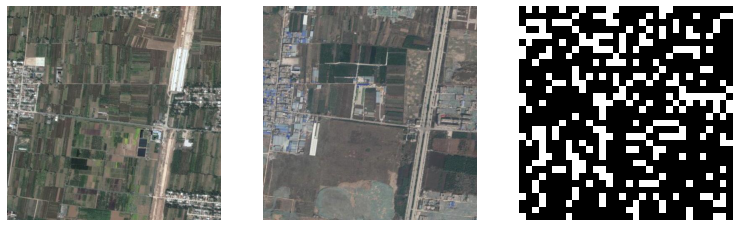

In [19]:
t1, t2 = (data_loader.load_folder('test', tp) for tp in ['t1', 't2'])
test_data = np.array([np.array([t1[i], t2[i]]) for i in range(t1.shape[0])])


def show_test(ind: int):
    print(test_data[ind].shape)
    output = np.asarray(model(np.array([test_data[ind]])))
    output = np.round(output)
    show_place((*test_data[ind], output.reshape((MASK_SIZE, MASK_SIZE))))
    print(output)
    print(np.max(output), np.sum(output))
    

show_test(1)

In [32]:
model.save('my_model.h5')

In [20]:
from tensorflow.keras.models import load_model
cool = load_model('best_model.h5')

In [21]:
print(cool.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_t1 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Input_t2 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 32, 32, 512)  14714688    Input_t1[0][0]                   
                                                                 Input_t2[0][0]                   
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 1024) 0           model_1[0][0]              

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy()])

In [27]:
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=1)
print(hist.history)

10/10 [==============================] - 249s 25s/step - loss: 448.6556 - accuracy: 0.3436 - val_loss: 5.1571 - val_accuracy: 0.0233
{'loss': [448.65557861328125], 'accuracy': [0.3436393141746521], 'val_loss': [5.157110214233398], 'val_accuracy': [0.023336589336395264]}


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def show_test_cool(ind: int):
    print(test_data[ind].shape)
    inputs = [np.array([test_data[ind][0]]), np.array([test_data[ind][1]])]
#     inputs = [preprocess_input(inp) for inp in inputs]
    result = cool(inputs=inputs)
    print(result)
    output = np.asarray(result[2])
    output = np.round(output)
    show_place((*test_data[ind], output.reshape((128, 128))))
    print(output)
    print(np.max(output), np.sum(output))
    

show_test_cool(1)

(2, 512, 512, 3)
